In [14]:
import torch

In [15]:
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git

  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /private/var/folders/cg/l243p36n10s5v1x_vrt2wzs80000gn/T/pip-req-build-mws2exhx
  Running command git clone -q https://github.com/ChaoningZhang/MobileSAM.git /private/var/folders/cg/l243p36n10s5v1x_vrt2wzs80000gn/T/pip-req-build-mws2exhx
You should consider upgrading via the '/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/bin/python3.8 -m pip install --upgrade pip' command.


In [16]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "./weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [17]:
from mobile_sam import SamAutomaticMaskGenerator

In [18]:
import cv2
import supervision as sv

In [19]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api


In [20]:
IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [21]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [22]:
# mask_generator = SamAutomaticMaskGenerator(mobile_sam)
# masks = mask_generator.generate(image_bgr)

In [24]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [25]:
# from jupyter_bbox_widget import BBoxWidget
#
# widget = BBoxWidget()
# widget.image = encode_image(IMAGE_PATH)
# widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [26]:
import numpy as np

default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

# box = widget.bboxes[0] if widget.bboxes else default_box
box = default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [27]:
predictor = SamPredictor(mobile_sam)
predictor.set_image(image_bgr)
masks, _, _ = predictor.predict(
    box=box,
    multimask_output=False
)

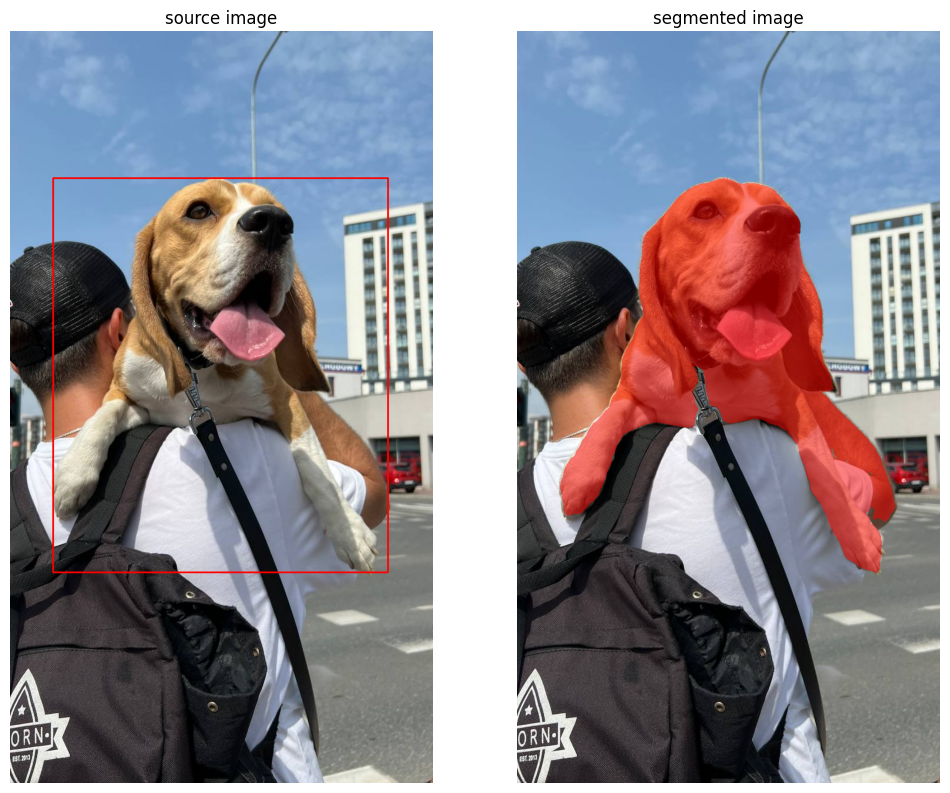

In [29]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)